# EA applied to RL through OpenAI gym

In [ ]:
import numpy
import sys
import os
from cStringIO import StringIO
import matplotlib.pyplot as plt

import gym

sys.path.append(os.path.abspath('./evolutionary-optimization/src'))
import OptimizerFactory

## Cart Pole

Four variable environment + Discrete binary decision [ref](https://github.com/openai/gym/wiki/CartPole-v0)

![cartpole.png](cartpole.png)

In [2]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

num_params = len(env.observation_space.high)
population_size = 5
num_iterations = 3

Discrete(2)
Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


### Random policy

In [1]:
def random_run(render=True, trials=20):
    bestreward = -float('inf')
    for i_trial in range(trials):
        observation = env.reset()
        totalreward = 0
        for t in xrange(sys.maxint):

            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)

            if render:
                env.render()

            totalreward += reward
            if done:
                print("Trial ended at {} time steps".format(t + 1))
                break
        if totalreward > bestreward:
            bestreward = totalreward
    return bestreward

In [4]:
random_run(render=False, trials=1)

Trial ended at 14 time steps


14.0

In [5]:
random_run(render=False, trials=population_size * num_iterations)

Trial ended at 10 time steps
Trial ended at 17 time steps
Trial ended at 13 time steps
Trial ended at 44 time steps
Trial ended at 23 time steps
Trial ended at 9 time steps
Trial ended at 27 time steps
Trial ended at 42 time steps
Trial ended at 17 time steps
Trial ended at 75 time steps
Trial ended at 31 time steps
Trial ended at 27 time steps
Trial ended at 15 time steps
Trial ended at 17 time steps
Trial ended at 22 time steps


75.0

### EA policies

In [6]:
def run_trial(parameters):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        action = 0 if numpy.matmul(parameters, observation) < 0 else 1

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def objective_function(parameters):
    assert len(parameters) == num_params
    return run_trial(parameters)

def ea(option):
    assert option in ['pso', 'ga', 'dea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    optimizer.optimizer.population_size = population_size
    optimizer.optimizer.max_iterations = num_iterations
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness, best_params

def sp(option):
    assert option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness, best_params


In [7]:
ea('pso')

#
# 2018-10-30 22:58:37.089968
#
# algorithm            = _PSOptimizer
# timeout              = None
# max_iterations       = 3
# population_size      = 5
# max_initial_velocity = 0.02
# omega                = 0.9
# phi_particle         = 0.3
# phi_swarm            = 0.1
#
# PARTICLES FOR ITERATION 1
# swarm_fitness           = 200.0
# best_average_fitness    = 81.8
# best_minimum_fitness    = 9.0
# best_maximum_fitness    = 200.0
# current_average_fitness = 81.8
# current_minimum_fitness = 9.0
# current_maximum_fitness = 200.0
#
# gen idv              fitness               param0               param1               param2               param3         best_fitness          best-param0          best-param1          best-param2          best-param3
    1   0         200.00000000           0.12747953           0.16417520           0.25067390           0.76638433         200.00000000           0.12747953           0.16417520           0.25067390           0.76638433
    1   1         132.00

(200.0, array([0.12747953, 0.1641752 , 0.2506739 , 0.76638433]))

### Comparison

In [8]:
def comp(options=['rand', 'nm', 'bfgs', 'pow', 'bh', 'sdea', 'pso', 'ga', 'dea']):

    # obsorb standard output, mystdout.getvalue()
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO() 
    
    to_plot = [[] for _ in options]
    repeats = 3
    
    params = []
    scores = []
    for i, option in enumerate(options):
        for _ in range(repeats):
            if option == 'rand':
                to_plot[i].append(random_run(render=False))
            else:
                if option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']:
                    score, param = sp(option)
                elif option in ['pso', 'ga', 'dea']:
                    score, param = ea(option)
                else:
                    assert False
                scores.append(score)
                params.append(param)
                to_plot[i].append(score)
        
    sys.stdout = old_stdout
    
    # print the solution, RL policy
    print(params[scores.index(max(scores))])

    plt.boxplot(to_plot)
    plt.ylabel('objective for maximization')
    plt.xticks(range(1, len(options) + 1), options)

/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/_differentialevolution.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


[-264580.7512858   612773.93374941  122012.43271125  590550.77303408]


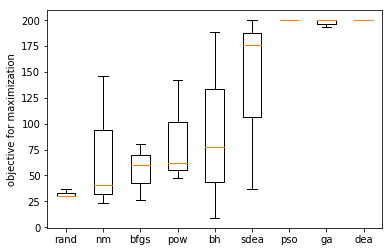

In [9]:
comp()

Note: Scipy methods, `nm`, `bfgs`, `pow`, `bh`, and `sdea`, are not bounded by the number of evaluations (15 in this example).  The rest of the comparison is fair, e.g. `rand` vs. EA-based methods `pso`, `ga`, and `dea`.

[0.25285201 0.50965226 0.84808156 0.91405624]


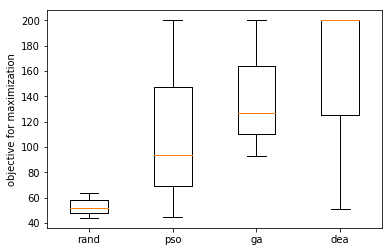

In [10]:
comp(['rand', 'pso', 'ga', 'dea'])

## Pendulum

Three variable environment + One variable decision [ref](https://github.com/openai/gym/wiki/Pendulum-v0)

![pendulum.png](pendulum.png)

In [11]:
env = gym.make('Pendulum-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

mid_dim = 1
num_params = \
    env.observation_space.shape[0] * mid_dim + \
    mid_dim * env.action_space.shape[0]

population_size = 100
num_iterations = 10

Box(1,)
Box(3,)
[1. 1. 8.]
[-1. -1. -8.]


In [12]:
random_run(render=False, trials=1)

Trial ended at 200 time steps


-931.9893688570431

In [13]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        action = numpy.dot(tmp, weights[1])

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(env.observation_space.shape[0], mid_dim)),
        numpy.zeros(shape=(mid_dim, env.action_space.shape[0]))
    ]
    index = 0
    for i in xrange(env.observation_space.shape[0]):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(env.action_space.shape[0]):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


[0.39595704 0.40460028 0.02740396 0.05730879]


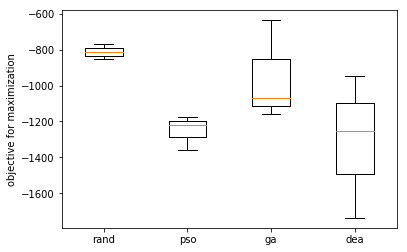

In [14]:
comp(options=['rand', 'pso', 'ga', 'dea'])

## Mountain Car

Two variable environment + Three-way discrete decision [ref](https://github.com/openai/gym/wiki/MountainCar-v0)


![mountcart](mountcart.png)

In [15]:
env = gym.make('MountainCar-v0')

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

observation_len = 2
action_len = 3

mid_dim = 1
num_params = \
    observation_len * mid_dim + \
    mid_dim * action_len

population_size = 50
num_iterations = 50

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


In [16]:
random_run(render=False, trials=1)

Trial ended at 200 time steps


-200.0

In [17]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        tmp = list(numpy.dot(tmp, weights[1]))
        action = tmp.index(max(tmp))

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(observation_len, mid_dim)),
        numpy.zeros(shape=(mid_dim, action_len))
    ]
    index = 0
    for i in xrange(observation_len):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(action_len):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


[0.         0.85080506 0.04283631 0.0450902  0.18169636]


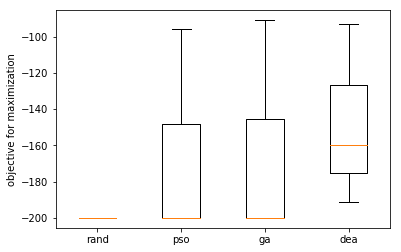

In [18]:
comp(options=['rand', 'pso', 'ga', 'dea'])

## Bipedal Walker

Twenty-three variable environment + Four variable decision [ref](https://github.com/openai/gym/wiki/BipedalWalker-v2)

![bipedalwalker](bipedalwalker.png)

In [19]:
env = gym.make('BipedalWalker-v2')

print(env.action_space)
print()

print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

population_size = 25
num_iterations = 25

observation_len = env.observation_space.shape[0]
action_len = env.action_space.shape[0]

mid_dim = 1
num_params = \
    observation_len * mid_dim + \
    mid_dim * action_len

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Box(4,)
()
Box(24,)
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


In [20]:
random_run(render=False, trials=1)

Trial ended at 1600 time steps


-75.1806774626248

In [21]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        action = numpy.dot(tmp, weights[1])

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(observation_len, mid_dim)),
        numpy.zeros(shape=(mid_dim, action_len))
    ]
    index = 0
    for i in xrange(observation_len):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(action_len):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)

[ 7.64813759 -0.09608283  0.36533906  1.46782177  0.87567499 -4.8901808
 -4.24294674 -2.07145994 -0.96360067 -4.41395663 -1.34501235  4.01436642
 -4.55113467  0.05687891  0.91085837  3.33697276 -8.36720484  4.33091532
 -0.07229983  0.48008032  4.85111041  2.18861942 -2.55380317  4.92200286
 -4.87279807  2.28367931  1.21910685 -0.91114758]


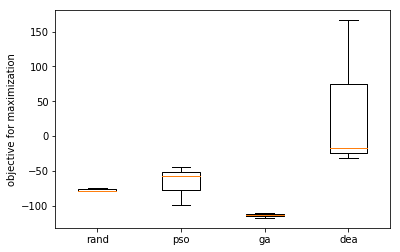

In [22]:
comp(options=['rand', 'pso', 'ga', 'dea'])